In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization,LeakyReLU,Input, Lambda,Concatenate,Flatten
from  tensorflow.keras.models import Sequential,Model 
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
tf.enable_eager_execution()

In [49]:
#we want to create a image colorization using GAN, I could have tried CNN but heard this works better
class ImageColorizer():
    def __init__(self):
        self.epochs = 100
        self.image_size = 64
        self.batch_size = 50
        self.filter_size = 64
        self.kernel_size = 3
        self.learning_rate = 0.001
    def generator_model(self):
        # generator is like this, we have grayscale image of size 50*50, and we first downsample and then upsample it
        #we use fully convolutional network, so we don't use Dense Layer here! 
        input_images = Input(shape=[32,32,1])
        #first layer
        layer1= Conv2D(self.filter_size,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform')(input_images)
        layer1=LeakyReLU(0.2)(layer1)
        #shape = 16*16*64
        
        layer2= Conv2D(self.filter_size*2,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform')(layer1)
        layer2=BatchNormalization()(layer2)
        layer2=LeakyReLU(0.2)(layer2)
        #shape =8*8*128
        layer3=Conv2D(self.filter_size*4,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform')(layer2)
        layer3=BatchNormalization()(layer3)
        layer3=LeakyReLU(0.2)(layer3) 
        #shape = 4*4*256        
        
        up_layer5 = Conv2DTranspose(self.filter_size*2,self.kernel_size,strides = (2,2),padding='same',use_bias=False)(layer3)
        up_layer5=BatchNormalization()(up_layer5)
        up_layer5=LeakyReLU(0.2)(up_layer5)
        #shape = 8*8*128
        up_layer_5_concat = Concatenate()([up_layer5, layer2])  


        up_layer6 = Conv2DTranspose(self.filter_size,self.kernel_size,strides = (2,2),padding='same',use_bias=False)(up_layer_5_concat)
        up_layer6 =BatchNormalization()(up_layer6)
        up_layer6 =LeakyReLU(0.2)(up_layer6)

        #shape = 16*16*64
        up_layer_6_concat = Concatenate()([up_layer6, layer1])        
        
        up_layer7 = Conv2DTranspose(3,self.kernel_size,strides = (2,2),padding='same',use_bias=False)(up_layer_6_concat)
        up_layer7 =BatchNormalization()(up_layer7)
        up_layer7 =LeakyReLU(0.2)(up_layer7)
        #shape = 32*32*3

        #shape = 32*32*3
        model = Model(input_images,up_layer7)
        return model
        
    def discriminator_model(self):
        # discriminator follows similar pattern, but has one sigmoid ouput whether the given network is from generator or from real data input
        input_images = Input(shape=[32,32,3])
        layer1= Conv2D(self.filter_size,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform')(input_images)
        layer1=LeakyReLU(0.2)(layer1)
        #shape = 16*16*64
        
        layer2= Conv2D(self.filter_size*2,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform')(layer1)
        layer2=BatchNormalization()(layer2)
        layer2=LeakyReLU(0.2)(layer2)
        #shape =8*8*128
        layer3=Conv2D(self.filter_size*4,self.kernel_size,(2,2),padding='same',use_bias=False,kernel_initializer='random_uniform')(layer2)
        layer3=BatchNormalization()(layer3)
        layer3=LeakyReLU(0.2)(layer3) 
        #shape = 4*4*256        
        
        up_layer5 = Conv2DTranspose(self.filter_size*2,self.kernel_size,strides = (2,2),padding='same',use_bias=False)(layer3)
        up_layer5=BatchNormalization()(up_layer5)
        up_layer5=LeakyReLU(0.2)(up_layer5)
        #shape = 8*8*128
        up_layer_5_concat = Concatenate()([up_layer5, layer2])  


        up_layer6 = Conv2DTranspose(self.filter_size,self.kernel_size,strides = (2,2),padding='same',use_bias=False)(up_layer_5_concat)
        up_layer6 =BatchNormalization()(up_layer6)
        up_layer6 =LeakyReLU(0.2)(up_layer6)

        #shape = 16*16*64
        up_layer_6_concat = Concatenate()([up_layer6, layer1])        
        
        up_layer7 = Conv2DTranspose(self.filter_size,self.kernel_size,strides = (2,2),padding='same',use_bias=False)(up_layer_6_concat)
        up_layer7 =BatchNormalization()(up_layer7)
        up_layer7 =LeakyReLU(0.2)(up_layer7)
        #shape = 32*32*64
        
        output = Conv2DTranspose(3,self.kernel_size,strides = (2,2),padding='same',use_bias=False)(up_layer7)
        final_output = LeakyReLU(0.2)(output)
        #shape = 64*64*3
        output = Flatten()(final_output)
        
        sigmoid_output = Dense(1,activation='sigmoid')(output)        
        model = Model(input_images,sigmoid_output)
        return model
    
    def generator_loss(self,fake_output,generated_image, actual_image,regularizer_lambda=0.01):
        mse = tf.reduce_mean(regularizer_lambda*tf.keras.losses.mean_absolute_error(generated_image, actual_image))
        return tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(fake_output),logits = fake_output) + mse
    
    def discriminator_loss(self,generated_image_from_generator,actual_image):
        actual_loss  = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(actual_image), logits = actual_image )
        fake_loss  = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(generated_image_from_generator), logits = generated_image_from_generator)
        return actual_loss + fake_loss
    def draw_images(self,generator,input_image_test):
        predict_image= generator(input_image_test)
        plt.imshow(predict_image[0,:,:,:],cmap='gray')
        plt.show()
    
    def train(self,gray_scale_image_dataset,color_image_dataset,test_image):
                
        generator = self.generator_model()
        discriminator = self.discriminator_model()
        
        gen_optimizer = tf.train.AdamOptimizer(self.learning_rate)
        dis_optimizer = tf.train.AdamOptimizer(self.learning_rate)
        for eachEpoch in range(self.epochs):
            
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                for i in range(20):
                    random.shuffle(gray_scale_image_dataset)
                    random.shuffle(color_image_dataset)
                gray_scale_dataset_image = gray_scale_image_dataset[:self.batch_size]
                color_dataset_image_batch = color_image_dataset[:self.batch_size]
                
                generated_image = generator(gray_scale_dataset_image)
                real_output = discriminator(color_dataset_image_batch)
                fake_output = discriminator(generated_image)
                gen_loss = self.generator_loss(fake_output,generated_image,color_dataset_image_batch)
                dis_loss = self.discriminator_loss(fake_output,real_output)
                print("Calculating Loss of Generator and Discriminator  generator = {} discriminator =  {} ".format(gen_loss[0],dis_loss[0]))            
            gen_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
            disc_gradients = disc_tape.gradient(dis_loss,discriminator.trainable_variables)
            print("APPLYING GRADENTS")
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
            dis_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
            
            print ("EPOCHS COMPLETED = {} ".format(eachEpoch))
            self.draw_images(generator,test_image)

            
        

In [4]:
#lets read the images
gray_scale_image_location = 'image-colorization/gray_scale.npy' 
colored_image_1_location = 'image-colorization/rgb_colored_images.npy'


In [5]:
gray_images  = np.load(gray_scale_image_location)
colored_image_1 = np.load(colored_image_1_location)

In [6]:
#resizing images! 
def imageResize(images,gray=False):
    resize_array = []
    for img in images:
        if gray:
            resized = cv2.resize(img,(32,32))
            resize_array.append(resized)
        else:
            resized = cv2.resize(img,(32,32))
            resize_array.append(resized)   
    return np.array(resize_array)

In [7]:
gray_images_resized = imageResize(gray_images,gray=True).astype(np.float32)[:colored_image_1.shape[0]]
color_images_resized = imageResize(colored_image_1).astype(np.float32)

In [21]:
gray_images_resized = gray_images_resized/255.0
color_images_resized = color_images_resized/255.0
gray_images_resized = np.reshape(gray_images_resized,(-1,32,32,1))
color_images_resized = np.reshape(color_images_resized,(-1,32,32,3))

In [37]:
test= cv2.imread('sanjiv.jpg',1)
test= cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
test = cv2.resize(test,(32,32))
test = np.reshape(test,(32,32,1)).astype(np.float32)
test = np.expand_dims(test,0)


In [50]:
image_colorizer = ImageColorizer()
gen = image_colorizer.generator_model()
dis = image_colorizer.discriminator_model()


Calculating Loss of Generator and Discriminator  generator = [0.4742247] discriminator =  [1.4481637] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 0 


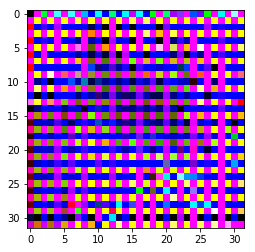

Calculating Loss of Generator and Discriminator  generator = [0.47423354] discriminator =  [1.4481107] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 1 


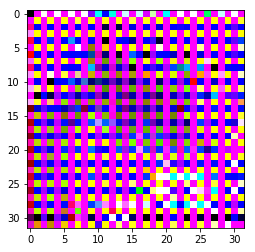

Calculating Loss of Generator and Discriminator  generator = [0.47522616] discriminator =  [1.4475023] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 2 


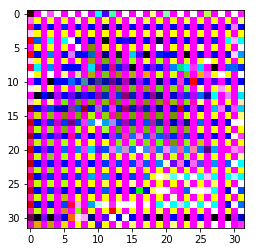

Calculating Loss of Generator and Discriminator  generator = [0.47715554] discriminator =  [1.446255] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 3 


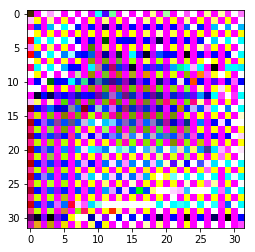

Calculating Loss of Generator and Discriminator  generator = [0.4806982] discriminator =  [1.4440024] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 4 


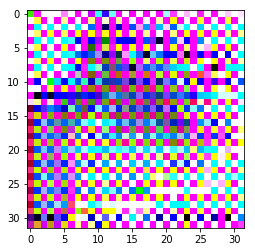

Calculating Loss of Generator and Discriminator  generator = [0.48681965] discriminator =  [1.4402763] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 5 


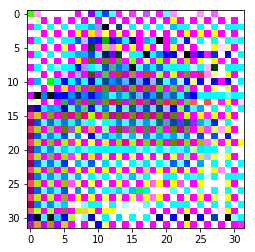

Calculating Loss of Generator and Discriminator  generator = [0.4972024] discriminator =  [1.4343733] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 6 


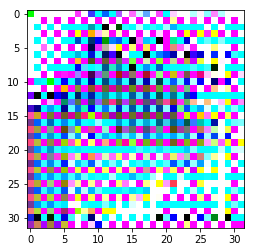

Calculating Loss of Generator and Discriminator  generator = [0.5148548] discriminator =  [1.4253542] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 7 


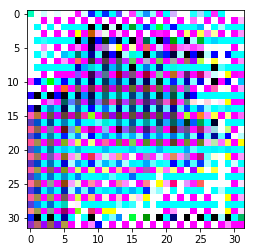

Calculating Loss of Generator and Discriminator  generator = [0.54490966] discriminator =  [1.4125888] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 8 


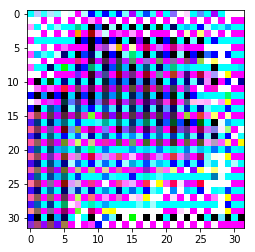

Calculating Loss of Generator and Discriminator  generator = [0.59324384] discriminator =  [1.3979621] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 9 


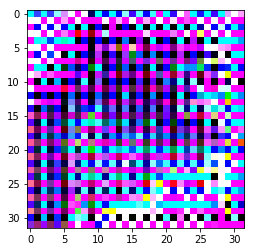

Calculating Loss of Generator and Discriminator  generator = [0.6528546] discriminator =  [1.3883762] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 10 


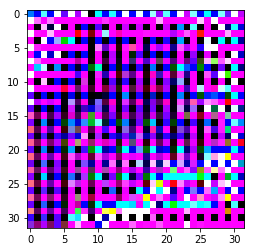

Calculating Loss of Generator and Discriminator  generator = [0.68689203] discriminator =  [1.3864002] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 11 


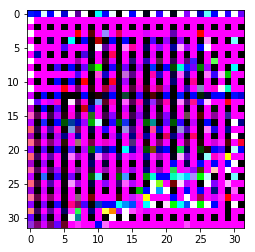

Calculating Loss of Generator and Discriminator  generator = [0.69304305] discriminator =  [1.3862935] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 12 


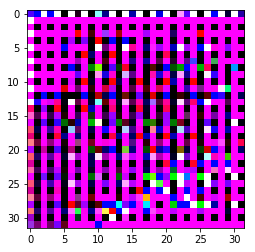

Calculating Loss of Generator and Discriminator  generator = [0.69339687] discriminator =  [1.3862942] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 13 


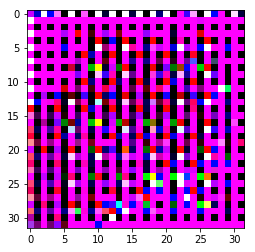

Calculating Loss of Generator and Discriminator  generator = [0.69341266] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 14 


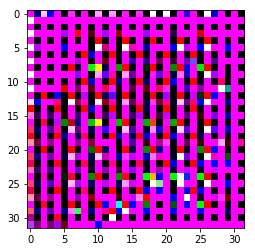

Calculating Loss of Generator and Discriminator  generator = [0.6934113] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 15 


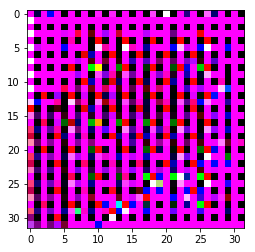

Calculating Loss of Generator and Discriminator  generator = [0.6934022] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 16 


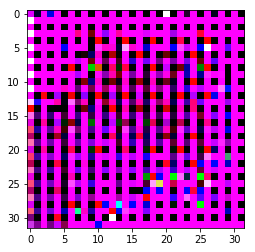

Calculating Loss of Generator and Discriminator  generator = [0.69339263] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 17 


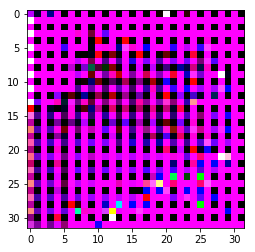

Calculating Loss of Generator and Discriminator  generator = [0.69338757] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 18 


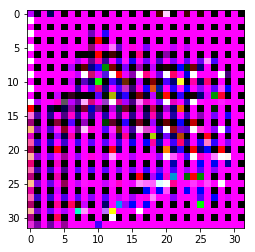

Calculating Loss of Generator and Discriminator  generator = [0.6933851] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 19 


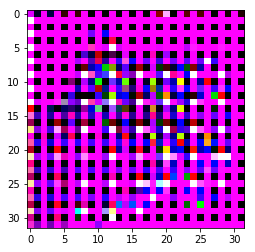

Calculating Loss of Generator and Discriminator  generator = [0.69337827] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 20 


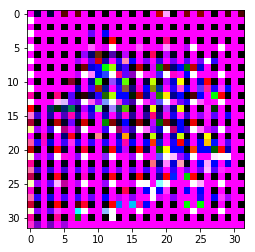

Calculating Loss of Generator and Discriminator  generator = [0.69336945] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 21 


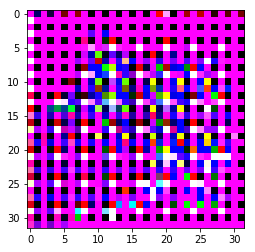

Calculating Loss of Generator and Discriminator  generator = [0.69335943] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 22 


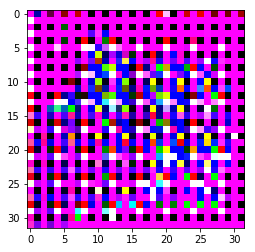

Calculating Loss of Generator and Discriminator  generator = [0.69334674] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 23 


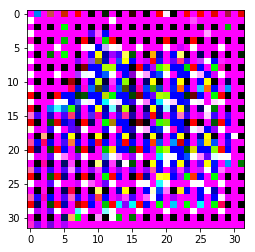

Calculating Loss of Generator and Discriminator  generator = [0.6933352] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 24 


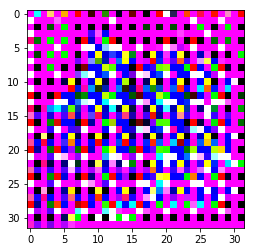

Calculating Loss of Generator and Discriminator  generator = [0.6933228] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 25 


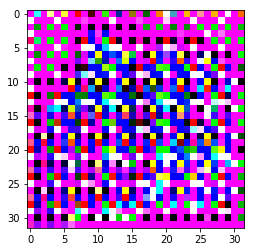

Calculating Loss of Generator and Discriminator  generator = [0.6933155] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 26 


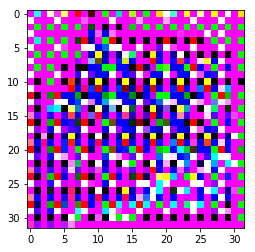

Calculating Loss of Generator and Discriminator  generator = [0.69330215] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 27 


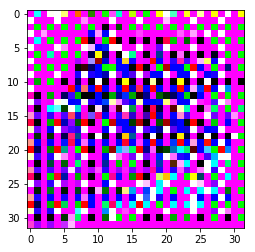

Calculating Loss of Generator and Discriminator  generator = [0.6932964] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 28 


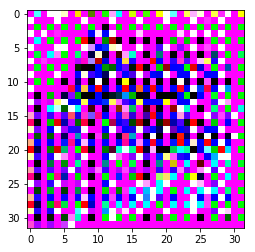

Calculating Loss of Generator and Discriminator  generator = [0.6932904] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 29 


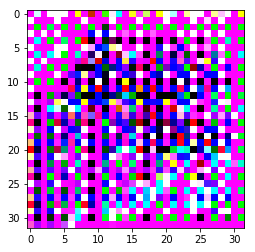

Calculating Loss of Generator and Discriminator  generator = [0.6932805] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 30 


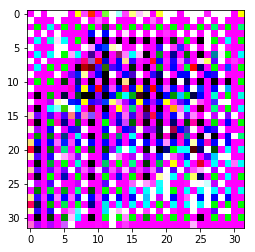

Calculating Loss of Generator and Discriminator  generator = [0.69327074] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 31 


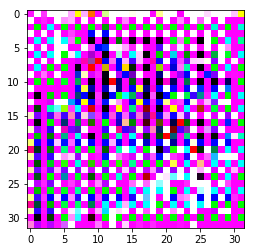

Calculating Loss of Generator and Discriminator  generator = [0.69326437] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 32 


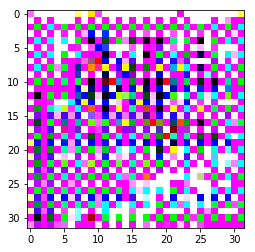

Calculating Loss of Generator and Discriminator  generator = [0.69325745] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 33 


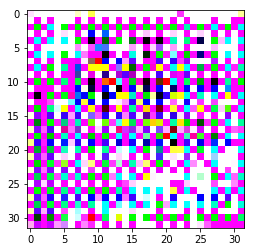

Calculating Loss of Generator and Discriminator  generator = [0.69325024] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 34 


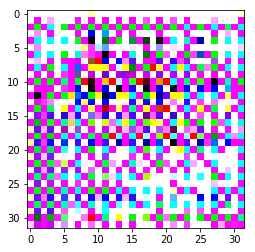

Calculating Loss of Generator and Discriminator  generator = [0.69324446] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 35 


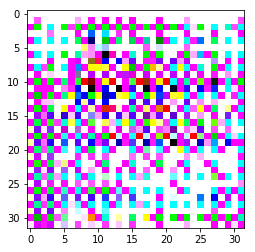

Calculating Loss of Generator and Discriminator  generator = [0.69324267] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 36 


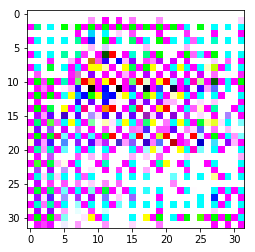

Calculating Loss of Generator and Discriminator  generator = [0.6932407] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 37 


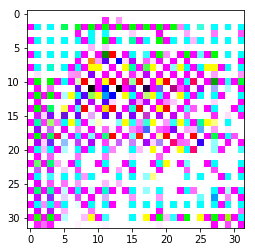

Calculating Loss of Generator and Discriminator  generator = [0.69323677] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 38 


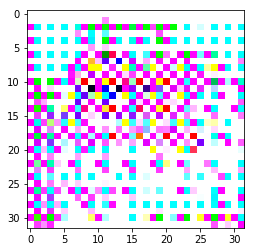

Calculating Loss of Generator and Discriminator  generator = [0.69323397] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 39 


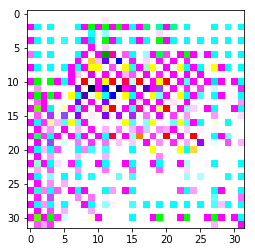

Calculating Loss of Generator and Discriminator  generator = [0.69323117] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 40 


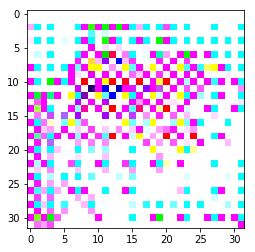

Calculating Loss of Generator and Discriminator  generator = [0.6932274] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 41 


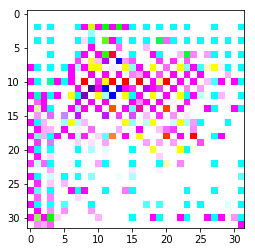

Calculating Loss of Generator and Discriminator  generator = [0.6932256] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 42 


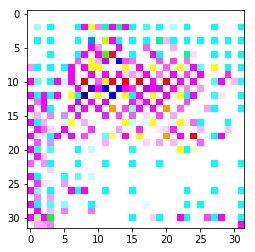

Calculating Loss of Generator and Discriminator  generator = [0.6932247] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 43 


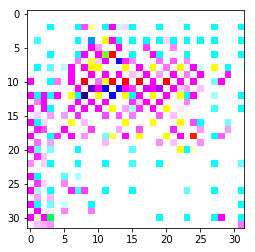

Calculating Loss of Generator and Discriminator  generator = [0.6932233] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 44 


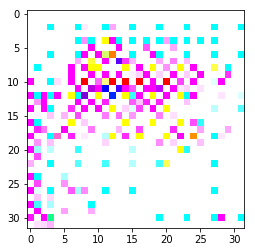

Calculating Loss of Generator and Discriminator  generator = [0.6932203] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 45 


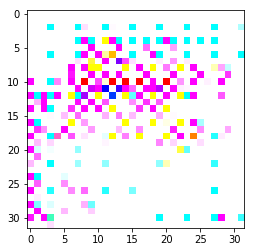

Calculating Loss of Generator and Discriminator  generator = [0.6932181] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 46 


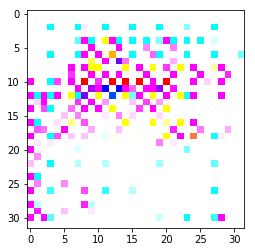

Calculating Loss of Generator and Discriminator  generator = [0.6932172] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 47 


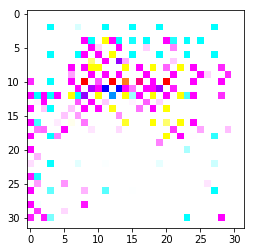

Calculating Loss of Generator and Discriminator  generator = [0.6932168] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 48 


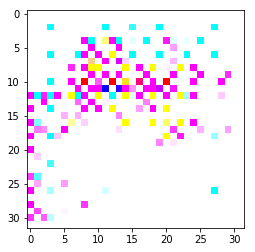

Calculating Loss of Generator and Discriminator  generator = [0.69321555] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 49 


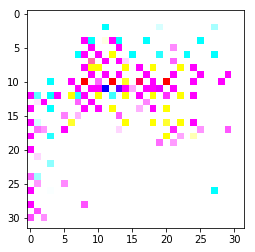

Calculating Loss of Generator and Discriminator  generator = [0.69321465] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 50 


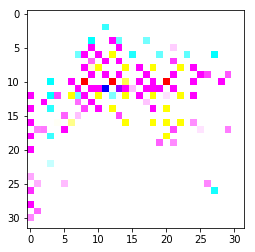

Calculating Loss of Generator and Discriminator  generator = [0.69321334] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 51 


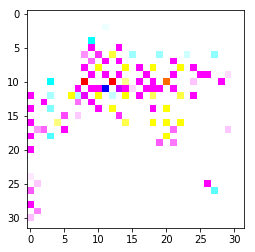

Calculating Loss of Generator and Discriminator  generator = [0.6932121] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 52 


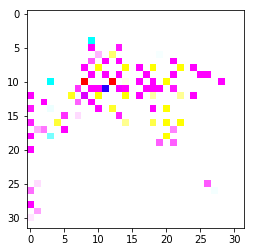

Calculating Loss of Generator and Discriminator  generator = [0.69321024] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 53 


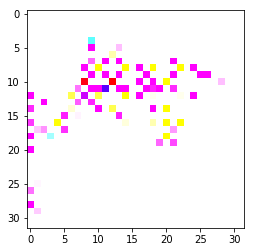

Calculating Loss of Generator and Discriminator  generator = [0.6932093] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 54 


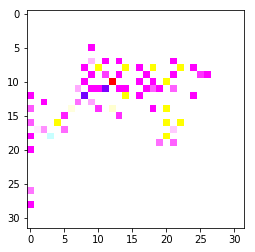

Calculating Loss of Generator and Discriminator  generator = [0.6932082] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 55 


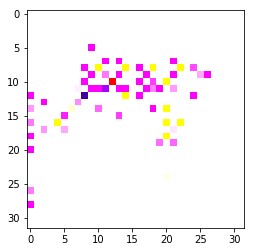

Calculating Loss of Generator and Discriminator  generator = [0.6932072] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 56 


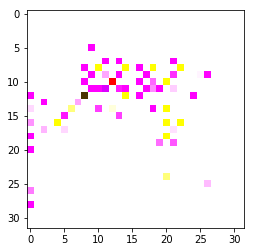

Calculating Loss of Generator and Discriminator  generator = [0.69320613] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 57 


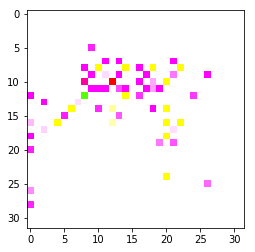

Calculating Loss of Generator and Discriminator  generator = [0.6932052] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 58 


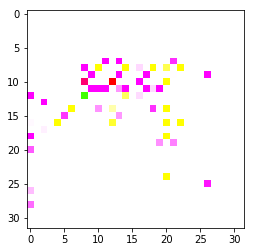

Calculating Loss of Generator and Discriminator  generator = [0.693204] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 59 


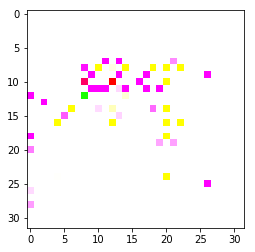

Calculating Loss of Generator and Discriminator  generator = [0.69320303] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 60 


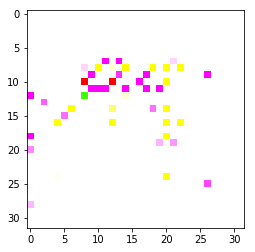

Calculating Loss of Generator and Discriminator  generator = [0.6932019] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 61 


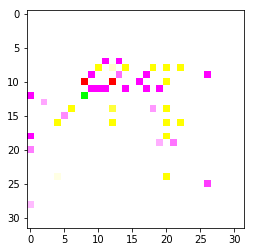

Calculating Loss of Generator and Discriminator  generator = [0.69320107] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 62 


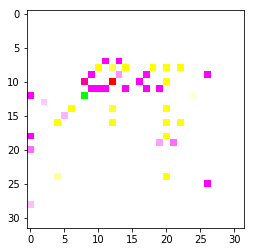

Calculating Loss of Generator and Discriminator  generator = [0.6932] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 63 


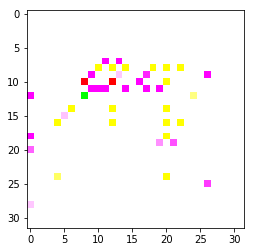

Calculating Loss of Generator and Discriminator  generator = [0.6931989] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 64 


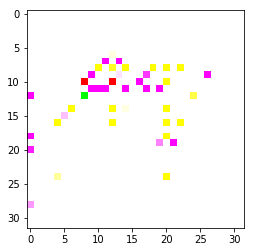

Calculating Loss of Generator and Discriminator  generator = [0.693198] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 65 


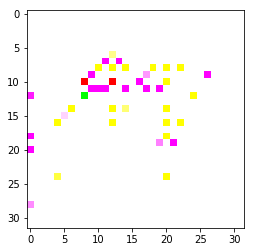

Calculating Loss of Generator and Discriminator  generator = [0.693197] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 66 


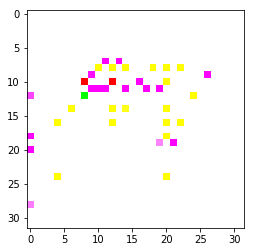

Calculating Loss of Generator and Discriminator  generator = [0.6931961] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 67 


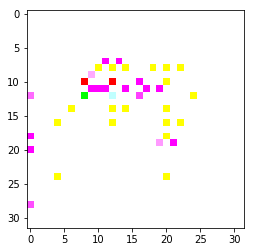

Calculating Loss of Generator and Discriminator  generator = [0.6931951] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 68 


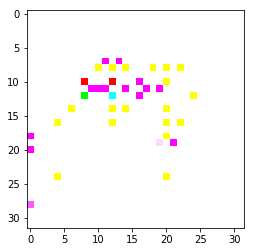

Calculating Loss of Generator and Discriminator  generator = [0.69319427] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 69 


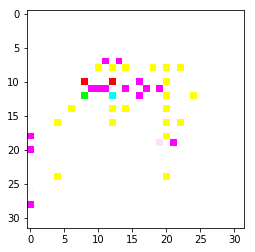

Calculating Loss of Generator and Discriminator  generator = [0.6931942] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 70 


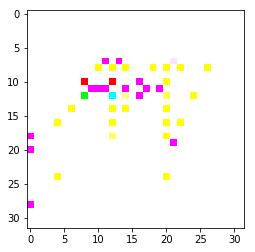

Calculating Loss of Generator and Discriminator  generator = [0.6931943] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 71 


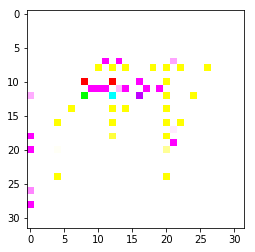

Calculating Loss of Generator and Discriminator  generator = [0.69319326] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 72 


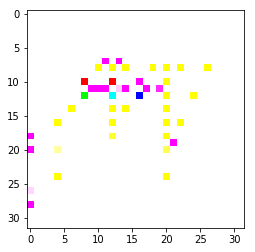

Calculating Loss of Generator and Discriminator  generator = [0.6931913] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 73 


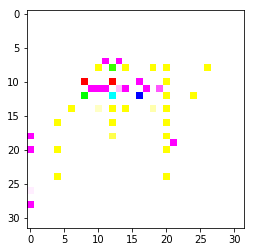

Calculating Loss of Generator and Discriminator  generator = [0.69319034] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 74 


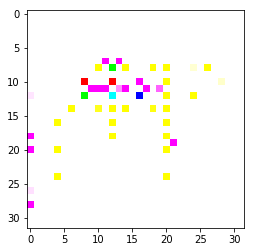

Calculating Loss of Generator and Discriminator  generator = [0.69319034] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 75 


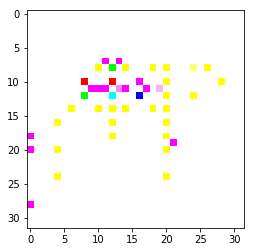

Calculating Loss of Generator and Discriminator  generator = [0.69318974] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 76 


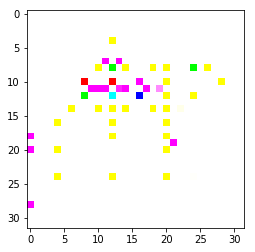

Calculating Loss of Generator and Discriminator  generator = [0.69318867] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 77 


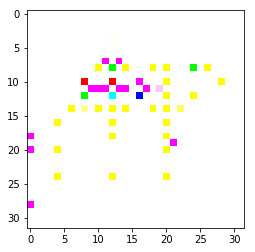

Calculating Loss of Generator and Discriminator  generator = [0.69318765] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 78 


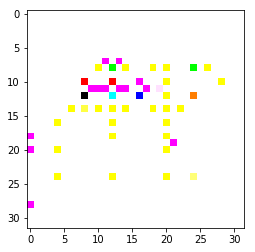

Calculating Loss of Generator and Discriminator  generator = [0.69318676] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 79 


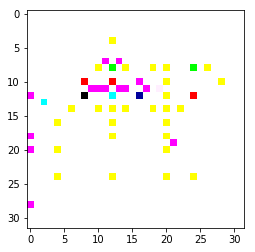

Calculating Loss of Generator and Discriminator  generator = [0.6931862] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 80 


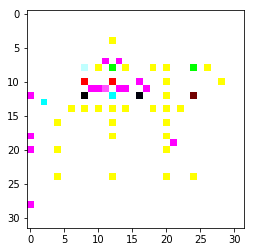

Calculating Loss of Generator and Discriminator  generator = [0.69318616] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 81 


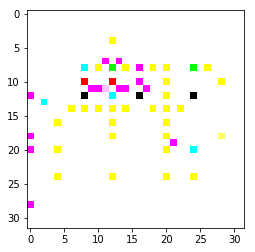

Calculating Loss of Generator and Discriminator  generator = [0.6931869] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 82 


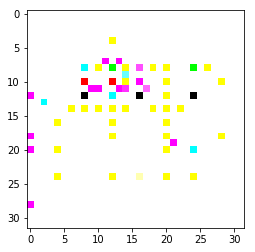

Calculating Loss of Generator and Discriminator  generator = [0.6931864] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 83 


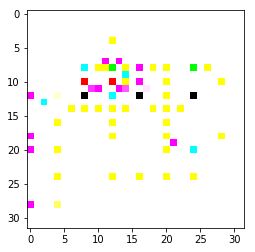

Calculating Loss of Generator and Discriminator  generator = [0.69318515] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 84 


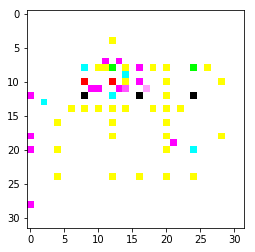

Calculating Loss of Generator and Discriminator  generator = [0.6931837] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 85 


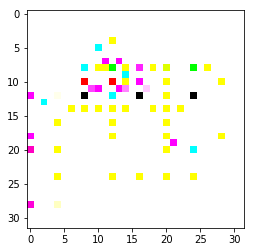

Calculating Loss of Generator and Discriminator  generator = [0.6931832] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 86 


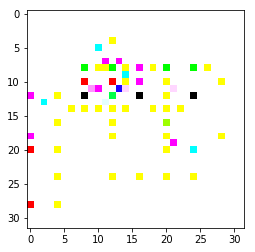

Calculating Loss of Generator and Discriminator  generator = [0.6931837] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 87 


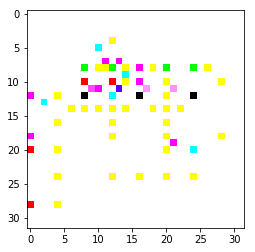

Calculating Loss of Generator and Discriminator  generator = [0.69318384] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 88 


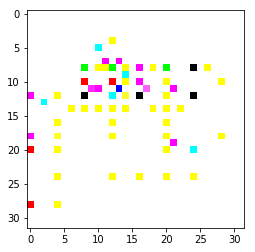

Calculating Loss of Generator and Discriminator  generator = [0.6931825] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 89 


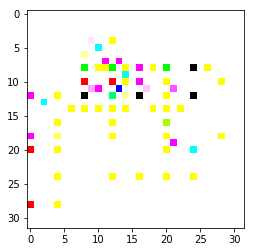

Calculating Loss of Generator and Discriminator  generator = [0.6931812] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 90 


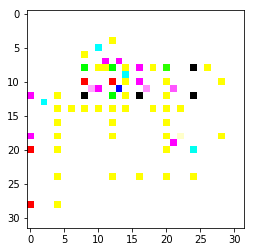

Calculating Loss of Generator and Discriminator  generator = [0.69318104] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 91 


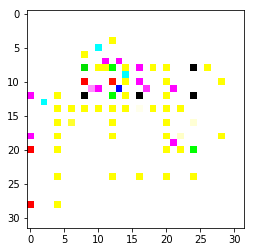

Calculating Loss of Generator and Discriminator  generator = [0.69318116] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 92 


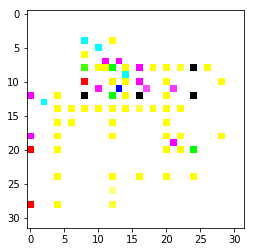

Calculating Loss of Generator and Discriminator  generator = [0.693181] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 93 


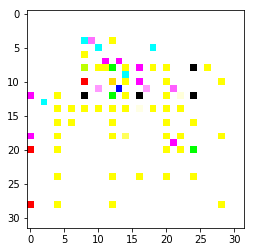

Calculating Loss of Generator and Discriminator  generator = [0.69318116] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 94 


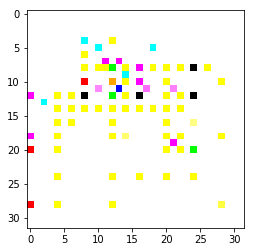

Calculating Loss of Generator and Discriminator  generator = [0.6931804] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 95 


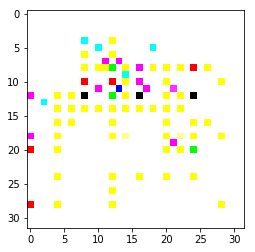

Calculating Loss of Generator and Discriminator  generator = [0.6931793] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 96 


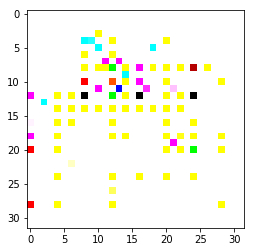

Calculating Loss of Generator and Discriminator  generator = [0.6931786] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 97 


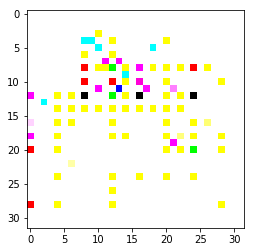

Calculating Loss of Generator and Discriminator  generator = [0.6931781] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 98 


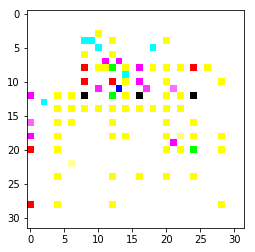

Calculating Loss of Generator and Discriminator  generator = [0.69317895] discriminator =  [1.3862944] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


APPLYING GRADENTS
EPOCHS COMPLETED = 99 


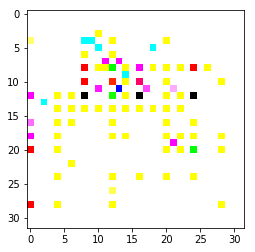

In [51]:
image_colorizer.train(gray_images_resized,color_images_resized,test)